In [1]:
import numpy as np
import cupy as cp
#import numpy as cp

import matplotlib.pyplot as plt
from PIL import Image

from load_dataset import load_dataset
from load_cached_weights import load_weights

import pandas as pd

In [2]:
# set path vars

#dataset_path = "C:\\Users\\user\\PycharmProjects\\my_cnn\\mnist_png"
dataset_path = 'mnist_png'
cached_weights_path = 'cache'

In [3]:
# activation functions and their derivatives

# sigmoid
def sigmoid(x):
    return 1/(1+cp.exp(-x))

# sigmoid derivative
def sigmoid_d(x):
    return cp.exp(-x) / cp.power(1 + cp.exp(-x), 2.)

# ReLU
def relu(x):
    return cp.maximum(x, 0)

# ReLU derivative
def relu_d(x):
    x[x<=0] = 0
    x[x>0] = 1
    return -x

# tanh
def tanh(x):
    return cp.tanh(x)

# tanh derivative
def tanh_d(x):
    return cp.power(cp.cosh(x), -2.)


# function to choose between the activation functions in place
def activation_function(Z, name, d=False):
    if d:
        if name == 'relu':
            return relu_d(Z)
        elif name == 'sigmoid':
            return sigmoid_d(Z)
        elif name == 'tanh':
            return tanh_d(Z)
    else:
        if name == 'relu':
            return relu(Z)
        elif name == 'sigmoid':
            return sigmoid(Z)
        elif name == 'tanh':
            return tanh(Z)


In [4]:
# load the MNIST dataset

dataset = load_dataset(dataset_path)
X = dataset['train']['X']
Y = dataset['train']['Y']

In [5]:
# convert X, Y to CuPy arrays

X = cp.array(X)
Y = cp.array(Y)

In [12]:
# load cached weights (if available)

cached_weights = load_weights(cached_weights_path)
W1 = cp.array(cached_weights['W']['W1'])
W2 = cp.array(cached_weights['W']['W2'])
W3 = cp.array(cached_weights['W']['W3'])

b1 = cp.array(cached_weights['b']['B1'])
b2 = cp.array(cached_weights['b']['B2'])
b3 = cp.array(cached_weights['b']['B3'])

#
weights = [W1, W2, W3]
biases = [b1, b2, b3]

In [6]:
# set the layer sizes

layer_sizes = [
    X.shape[0],
    500,
    Y.shape[0]
]

In [7]:
# set the activations

activations = [
    'tanh',
    'sigmoid',
]

assert(len(layer_sizes) == (len(activations) + 1))

In [15]:
# param init according to layer sizes
# !!! SKIP !!!
# IF YOU HAVE LOADED THE CACHED ONES

weights = [cp.random.randn(layer_sizes[index], layer_sizes[index - 1]) for index in range(1, len(layer_sizes))]
biases = [cp.zeros((layer_sizes[index], 1)) for index in range(1, len(layer_sizes))]

In [9]:
def forward(X, weights, biases, activations):
    A = [X]
    for weight, bias, activation in zip(weights, biases, activations):
        Z = cp.dot(weight, A[-1]) + bias
        A.append(activation_function(Z, activation))

    return A

In [10]:
def backward(A, dAL, weights, activations):
    dA = [dAL]
    dZ = [activation_function(A[-1], activations[-1], d=True)]
    dW = [cp.dot(dA[-1] * dZ[-1], A[-2].T)]
    db = [cp.sum(dZ[-1], axis=1, keepdims=True)]

    for index in range(1, len(weights)):
        da = cp.dot(weights[-index].T, dA[-1] * dZ[-1])

        dz = activation_function(A[-1-index],
                                     activations[-1-index],
                                     d=True)

        dW.append(cp.dot(da * dz, A[-2-index].T))
        db.append(cp.sum(dz, axis=1, keepdims=True))

        dA.append(da)
        dZ.append(dz)

    dW.reverse()
    db.reverse()

    return dW, db

In [18]:
# train the model

iterations = 75
print_cost = True
print_at_i = 10

samples = X.shape[1] # number of training samples (60000 here)

learning_rate = .000005

costs = []

for i in range(iterations):

    # forward propagation
    #   push input data through the network
    A = forward(X, weights, biases, activations)

    # MSE
    #   cost function, to compute the error
    # TODO: try different cost functions or different metrics
    cost = cp.sum(cp.power(Y - A[-1], 2.)) / samples
    #cost = -(1.0/samples) * cp.sum(Y*cp.log(A[-1]) + (1-Y)*cp.log(1-A[-1]))
    costs.append(float(cp.squeeze(cost)))

    if print_cost and i % print_at_i == 0:
        print('Cost: {} @ i = {}'.format(cost, i))


    # backward propagation
    #   adjust the weights and biases to fit the data

    # compute the derivatives of the weights and biases
    dAL = 2 * (Y - A[-1])
    #dAL = -(A[-1]-Y)/(A[-1]*(1-A[-1]))
    dW, db = backward(A, dAL, weights,activations)

    # update parameters
    weights = [weights[index] + learning_rate * dW[index] for index in range(len(weights))]
    biases = [biases[index] + learning_rate * db[index] for index in range(len(biases))]

Cost: 0.8381786427771443 @ i = 0
Cost: 0.7693721014123623 @ i = 10
Cost: 0.7283076000131763 @ i = 20
Cost: 0.7004358328607393 @ i = 30
Cost: 0.6825419325456663 @ i = 40
Cost: 0.6738520561244881 @ i = 50
Cost: 0.6700656356492796 @ i = 60
Cost: 0.6736677577301777 @ i = 70


0 [6.65084971e-07]
1 [1.26359854e-06]
2 [0.00012566]
3 [1.78249374e-09]
4 [0.99988428]
5 [4.14991036e-13]
6 [0.04672058]
7 [1.82607714e-05]
8 [9.02769869e-06]
9 [1.28937826e-08]
The system predicted:  4


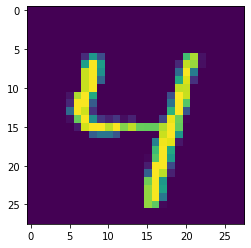

In [20]:
# load a sample image from the test dataset
# to evaluate the model

img = np.asarray(
        Image.open(
            dataset_path + "/testing/4/210.png"
        )
    )
plt.imshow(img)
img = img.reshape((img.shape[0] * img.shape[1]))[:, cp.newaxis]

X_n = img

# to CuPy
X_n = cp.array(X_n) / 255

# predict it
prediction = forward(X_n, weights, biases, activations)[-1]
[print(index, p)for index, p in enumerate(list(prediction))]
print('The system predicted: ', list(prediction).index(max(list(prediction))))

In [19]:
# validate

Y_prediction_train = forward(cp.array(dataset['train']['X']),
                            weights, biases, activations)[-1]
Y_train = cp.array(dataset['train']['Y'])


Y_prediction_test = forward(cp.array(dataset['test']['X']),
                            weights, biases, activations)[-1]
Y_test = cp.array(dataset['test']['Y'])

print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

train accuracy: 91.84611993565935 %
test accuracy: 92.0105621594752 %


In [14]:
# save weights and biases

weights_to_save = list(map(cp.asnumpy, weights.copy()))
biases_to_save = list(map(cp.asnumpy, biases.copy()))

[pd.DataFrame(df).to_csv('cache/W/w{}.csv'.format(index + 1), index=False) for index, df in enumerate(weights_to_save)]

[pd.DataFrame(df).to_csv('cache/b/b{}.csv'.format(index + 1), index=False) for index, df in enumerate(biases_to_save)]

[None, None, None]

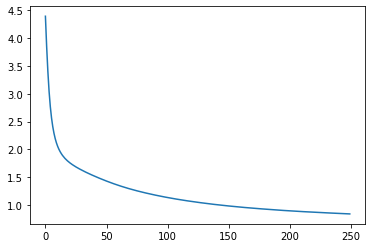

In [17]:
# plot
plt.plot(range(len(costs)), costs)
plt.show()
